In [22]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFECV, RFE

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("claim-fraud-clean.csv", index_col='policy_number')
df.head()

,umbrella_limit,bodily_injuries,policy_deductable,capital-loss,total_claim_amount,number_of_vehicles_involved,auto_year,policy_annual_premium,age,capital-gains,...,police_report_available,insured_sex,insured_occupation,incident_severity,incident_state,policy_state,insured_education_level,authorities_contacted,property_damage,collision_type
policy_number,,,,,,,,,,,,,,,,,,,,,
521585,0.0,1,0.333333,0.000000,0.622801,1,2004,0.603112,48,0.530348,...,YES,MALE,craft-repair,Major Damage,SC,OH,MD,Police,YES,Side Collision
342868,0.5,0,1.000000,0.000000,0.043285,1,2007,0.473214,42,0.000000,...,NO,MALE,machine-op-inspct,Minor Damage,VA,IN,MD,Police,NO,Rear Collision
687698,0.5,2,1.000000,0.000000,0.300906,3,2007,0.606972,29,0.349254,...,NO,FEMALE,sales,Minor Damage,NY,OH,PhD,Police,NO,Rear Collision
227811,0.6,1,1.000000,0.561656,0.551298,1,2014,0.608582,41,0.486567,...,NO,FEMALE,armed-forces,Major Damage,OH,IL,PhD,Police,NO,Front Collision
367455,0.6,0,0.333333,0.414041,0.055739,1,2009,0.712760,44,0.656716,...,NO,MALE,sales,Minor Damage,NY,IL,Associate,Police,NO,Rear Collision


In [3]:
df['fraud_reported'] = (
    df['fraud_reported']
    .str.strip()
    .str.upper()
    .map({'Y': 1, 'N': 0})
)

In [4]:
X = df.drop(columns='fraud_reported')
y = df['fraud_reported']

In [5]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,    
    random_state=132147
)

In [6]:
model_lr = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('selector_auto', RFECV( 
    estimator= LogisticRegression(
            max_iter=1000,
            class_weight='balanced'),
    step=1, 
    cv=5, 
    scoring='recall'))
    ]
)

In [7]:
model_knn = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('selector_auto', RFECV( 
    estimator= KNeighborsClassifier(
           n_neighbors=5  
    ),
    step=1, 
    cv=5, 
    scoring='recall'))
    ]
)

In [8]:
model_dt = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('selector_auto', RFECV( 
    estimator=DecisionTreeClassifier(random_state=45532),
    step=1, 
    cv=5, 
    scoring='recall'))
    ]
)

In [9]:
model_rf = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('selector_auto', RFECV( 
    estimator=RandomForestClassifier(n_estimators=100,random_state=45532),
    step=1, 
    cv=5, 
    scoring='recall'))
    ]
)

In [10]:
model_xgb = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('selector_auto', RFECV( 
    estimator=xgb.XGBClassifier( 
        max_depth=12, 
        learning_rate=0.02
    ),
    step=1, 
    cv=5, 
    scoring='recall'))
    ]
)

In [11]:
model_xgb1 = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('selector_auto', RFECV( 
    estimator= xgb.XGBClassifier(
    max_depth=3,         
    learning_rate=0.05,   
    n_estimators=1000,  
    min_child_weight=4,    
    subsample=0.7,          
    colsample_bytree=0.7,   
    random_state=42,
    n_jobs=-1
),
    step=1, 
    cv=5, 
    scoring='recall'))
    ]
)

In [12]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=54623)
models = [model_lr,model_dt,model_rf,model_xgb,model_xgb1]
acc = []

for no, model in enumerate(models):
    model.fit(X_train,y_train)
    n_optimal = model.named_steps['selector_auto'].n_features_
    print(f"Jumlah fitur optimal yang ditemukan RFECV model ke {no}: {n_optimal}")
    step_encoder = model.named_steps['preprocess']
    all_var = step_encoder.get_feature_names_out()
    step_rfecv = model.named_steps['selector_auto']
    mask = step_rfecv.support_
    var_final = all_var[mask]
    print(var_final.tolist())
    
    y_pred = model.predict(X_test) 
    
    accuracy = f1_score(y_test, y_pred)
    acc.append(accuracy)
    
    print(f"F1 Score Model-{no} : {accuracy*100:.2f}%")

Jumlah fitur optimal yang ditemukan RFECV model ke 0: 4
['cat__insured_hobbies_chess', 'cat__insured_hobbies_cross-fit', 'cat__incident_severity_Minor Damage', 'cat__incident_severity_Trivial Damage']
F1 Score Model-0 : 50.59%
Jumlah fitur optimal yang ditemukan RFECV model ke 1: 58
['cat__policy_csl_250/500', 'cat__auto_make_Audi', 'cat__auto_make_Saab', 'cat__auto_make_Volkswagen', 'cat__insured_hobbies_board-games', 'cat__insured_hobbies_chess', 'cat__insured_hobbies_cross-fit', 'cat__insured_hobbies_exercise', 'cat__insured_hobbies_movies', 'cat__insured_hobbies_paintball', 'cat__insured_hobbies_reading', 'cat__incident_city_Hillsdale', 'cat__insured_relationship_not-in-family', 'cat__insured_occupation_armed-forces', 'cat__insured_occupation_craft-repair', 'cat__insured_occupation_exec-managerial', 'cat__insured_occupation_farming-fishing', 'cat__insured_occupation_handlers-cleaners', 'cat__insured_occupation_machine-op-inspct', 'cat__insured_occupation_other-service', 'cat__insur

In [13]:
for i, accu in enumerate(acc):
    print(f"Model {i}: {accu:.4f}")

Model 0: 0.5059
Model 1: 0.4771
Model 2: 0.5545
Model 3: 0.6885
Model 4: 0.6723


### Best Model, XGBoost 

In [18]:
best_model = model_xgb.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       151
           1       0.58      0.86      0.69        49

    accuracy                           0.81       200
   macro avg       0.76      0.83      0.78       200
weighted avg       0.85      0.81      0.82       200



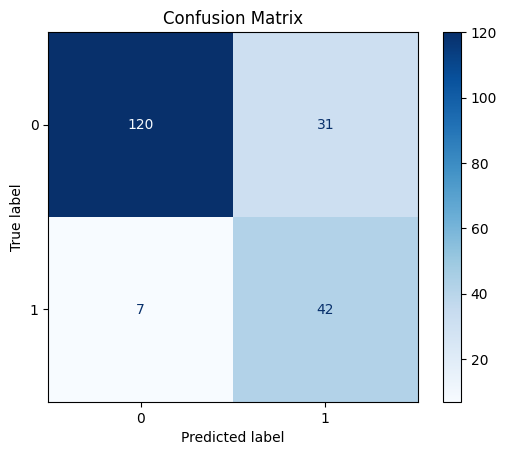

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [27]:
y_proba = best_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.5, 1.0, 0.001)
best_thresh = 0.5
best_f1 = 0
print(f"{'Threshold':<10} | {'F1-Score':<10} | {'Precision':<10} | {'Recall':<10}")

for th in thresholds:
    preds = (y_proba > th).astype(int)
    f1 = f1_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    #print(f"{th:.2f}       | {f1:.4f}     | {prec:.4f}     | {rec:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = th
        
print(f"Threshold Terbaik (F1 Tertinggi): {best_thresh}")

Threshold  | F1-Score   | Precision  | Recall    
Threshold Terbaik (F1 Tertinggi): 0.5
